gray image


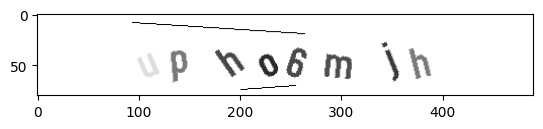

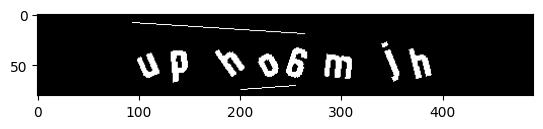

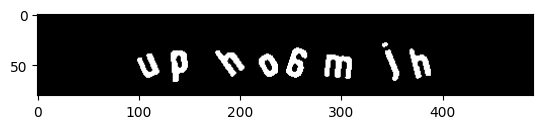

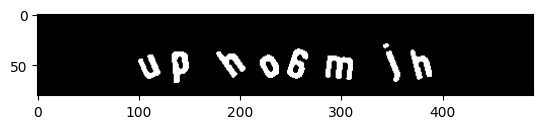

area:  319.5
Width of bounding box:  27
area:  287.0
Width of bounding box:  19
area:  214.0
Width of bounding box:  22
area:  266.0
Width of bounding box:  29
area:  346.5
Width of bounding box:  17
area:  152.5
Width of bounding box:  14
area:  251.0
Width of bounding box:  21
area:  334.0
Width of bounding box:  21
area:  14.5
Average width of characters:  22


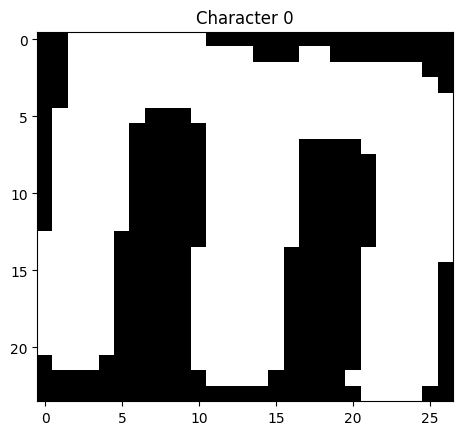

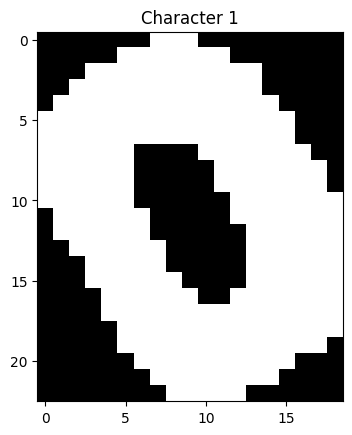

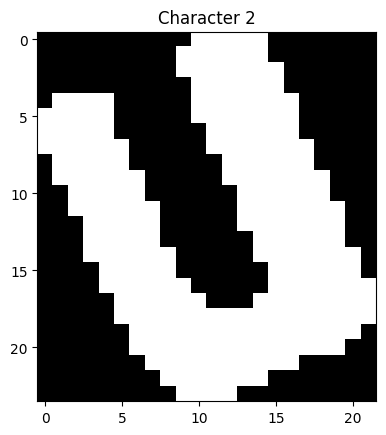

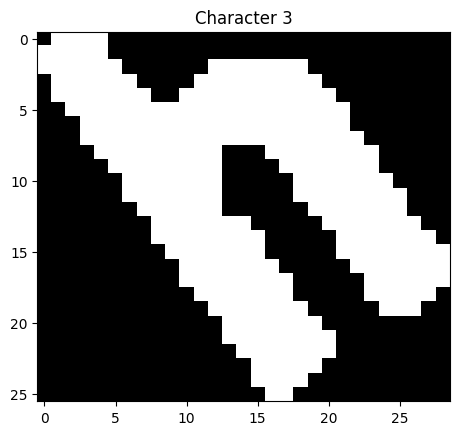

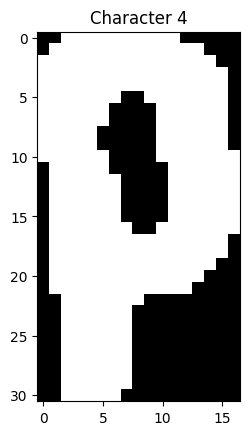

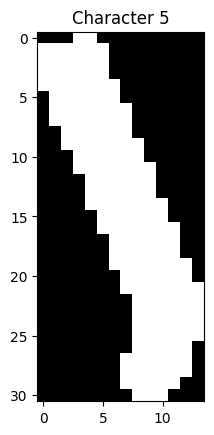

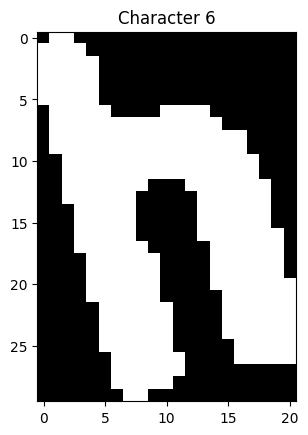

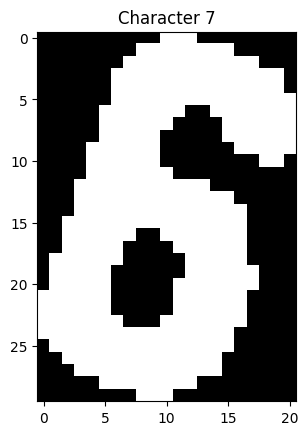

Segmentation completed!


In [8]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
    

# Create output folder for segmented characters
output_folder = "extracted_letter_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the CAPTCHA image
image_path = "train/upho6mjh-0.png"  
image = cv2.imread(image_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("gray image")
plt.imshow(img, cmap='gray')
plt.show()

img = cv2.equalizeHist(img)

im_bw_inverted = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 2)


plt.imshow(im_bw_inverted, cmap='gray')
plt.show()




im_bw_inverted = cv2.medianBlur(im_bw_inverted, 3)
plt.imshow(im_bw_inverted, cmap='gray')
plt.show()
 


# Adjust kernel size for closing operation
kernel = np.ones((2, 2), np.uint8)  # Larger kernel for closing
closed = cv2.morphologyEx(im_bw_inverted, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed, cmap='gray')
plt.show()


# Find contours again after applying closing operation
cnts = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

min_width = float("inf")
widths = []
min_area = 20  # Lowered min area to capture smaller parts like dots
image_number = 0


for c in cnts:
    area = cv2.contourArea(c)
    print("area: ", area)
    if area > min_area:
        x, y, w, h = cv2.boundingRect(c)
        print("Width of bounding box: ", w)
        # print the image segment
        ROI = closed[y:y+h, x:x+w]
        
        widths.append(w)
        
mean = np.mean(widths)
std_dev = np.std(widths)
threshold = mean + std_dev 
filtered_numbers = [num for num in widths if num <= threshold]

average = np.max(filtered_numbers)
print("Average width of characters: ", average)


for c in cnts:
    area = cv2.contourArea(c)
    x, y, w, h = cv2.boundingRect(c)
    
    # Check if contour width is significantly larger than min_width
    if w > 2 * average and area > min_area:
        # Divide wide contour into smaller pieces of width ~ min_width
        num_segments = int(round(w / average))
        segment_width = w // num_segments

        for i in range(num_segments):
            # Define each segment's bounding box
            x_segment = x + i * segment_width
            w_segment = segment_width if i < num_segments - 1 else (w - i * segment_width)
            ROI = closed[y:y+h, x_segment:x_segment + w_segment]
            
            # Save each segment as an individual image
            cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
            plt.imshow(ROI, cmap='gray')
            plt.title(f"Segment {image_number}")
            plt.show()
            image_number += 1

    elif area > min_area:
        # If contour width is close to min_width, save as is
        ROI = closed[y:y+h, x:x+w]
        cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
        plt.imshow(ROI, cmap='gray')
        plt.title(f"Character {image_number}")
        plt.show()
        image_number += 1


print("Segmentation completed!")


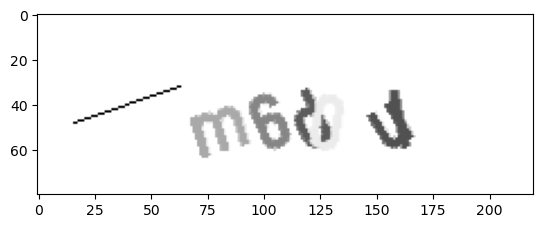

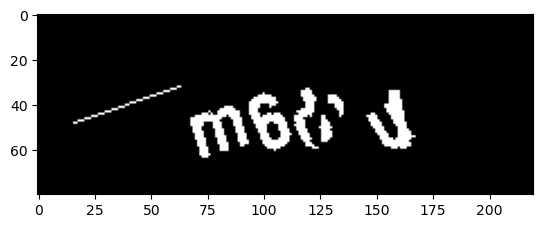

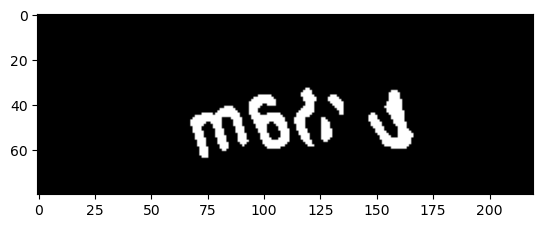

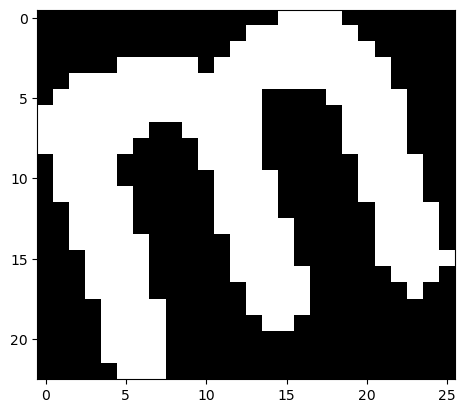

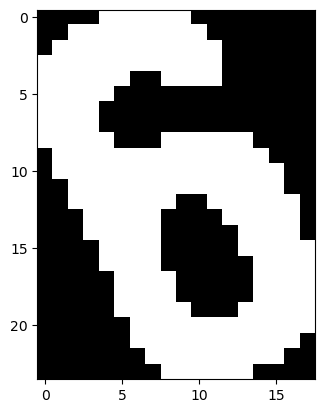

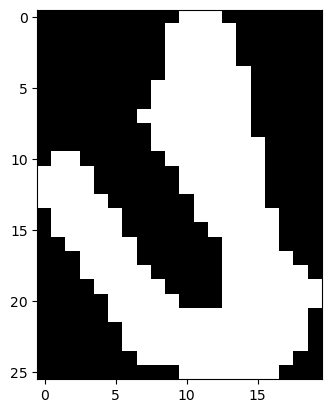

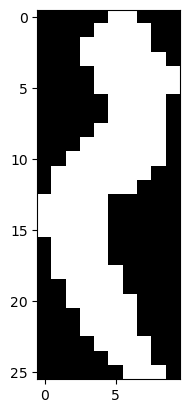

Segmentation completed!


In [15]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
    

# Create output folder for segmented characters
output_folder = "extracted_letter_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
counts = {}

# Load the CAPTCHA image
image_path = "train/m6d0ul-0.png"  
image = cv2.imread(image_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

im_bw_inverted = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 2)

plt.imshow(im_bw_inverted, cmap='gray')
plt.show()


im_bw_inverted = cv2.medianBlur(im_bw_inverted, 3)
plt.imshow(im_bw_inverted, cmap='gray')
plt.show()

# Adjust kernel size for closing operation
kernel = np.ones((1, 1), np.uint8)  # Larger kernel for closing
closed = cv2.morphologyEx(im_bw_inverted, cv2.MORPH_CLOSE, kernel)

# Find contours again after applying closing operation
cnts = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

min_area = 50  # Lowered min area to capture smaller parts like dots
image_number = 0

for c in cnts:
    area = cv2.contourArea(c)
    if area > min_area:
        x, y, w, h = cv2.boundingRect(c)
        
        # check for overlapping boxes
        if w / h > 1.25 :
            print("Splitting character...")
            half_width = int(w / 2)
            cv2.rectangle(image, (x, y), (x + half_width, y + h), (36, 255, 12), 2)
            cv2.rectangle(image, (x + half_width, y), (x + w, y + h), (36, 255, 12), 2)
            ROI = closed[y:y+h, x:x+half_width]
            plt.imshow(ROI, cmap='gray')
            plt.show()
            cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
            image_number += 1
            ROI = closed[y:y+h, x+half_width:x+w]
            plt.imshow(ROI, cmap='gray')
            plt.show()
            cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
            image_number += 1
            continue
        
        
        # Draw a rectangle around each detected character
        cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 2)
        # Extract each character as a Region of Interest (ROI)
        ROI = closed[y:y+h, x:x+w]
        plt.imshow(ROI, cmap='gray')
        plt.show()
        # Save the character as an individual image
        cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
        image_number += 1

print("Segmentation completed!")
